In [190]:
#Importações para Manipulação e Análise de Dados
import pandas as pd
import numpy as np

#Importações para Visualização de Dados 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from matplotlib.ticker import FuncFormatter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Importações para Machine Learning e Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from textblob import TextBlob
import xgboost as xgb



#Importação para Salvar o Modelo
import joblib

#Estilo estético para os gráficos do seaborn
sns.set_style('whitegrid')
#Tamanho padrão para as figuras do matplotlib
plt.rcParams['figure.figsize'] = (12, 6)

In [73]:
# Carrega o conjunto de dados a partir do arquivo CSV
df_filmes_original = pd.read_csv('data\desafio_indicium_imdb.csv', index_col=0)

# Exibe as primeiras 5 linhas para uma inspeção inicial
print("Amostra dos dados:")
display(df_filmes_original.head())

Amostra dos dados:


<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\2762237030.py:2: SyntaxWarning: invalid escape sequence '\d'
  df_filmes_original = pd.read_csv('data\desafio_indicium_imdb.csv', index_col=0)


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
1,The Godfather,1972,A,175 min,"Crime, Drama",9.20,An organized crime dynasty's aging patriarch t...,100.00,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.00,When the menace known as the Joker wreaks havo...,84.00,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.00,The early life and career of Vito Corleone in ...,90.00,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.00,A jury holdout attempts to prevent a miscarria...,96.00,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.90,Gandalf and Aragorn lead the World of Men agai...,94.00,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


In [74]:
# Exibe informações sobre o DataFrame, incluindo tipos de dados e valores não nulos
print("\nInformações do DataFrame:")
df_filmes_original.info()


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, 1 to 999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 124.9+ KB


In [75]:
# Verificar se existem linhas duplicadas
num_duplicatas = df_filmes_original.duplicated().sum()
print(f"Número de linhas duplicadas no dataset: {num_duplicatas}")

Número de linhas duplicadas no dataset: 0


In [76]:
# Calcula e exibe a contagem de valores ausentes para cada coluna
valores_ausentes = df_filmes_original.isnull().sum()
print(valores_ausentes)

Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64


In [77]:
# Copia o dataframe para não alterar o original
df_filmes = df_filmes_original.copy()

É notavel que exitem colunas importantes com valores ausentes, agora é preciso tratar cada uma de forma especifica para não generalizar. 

Como já havia percebido anteriormente a coluna Released_Year possui uma linha com valores trocados, que é o ano de laçamento e o certificado. Dessa forma realizei a troca manualmente. 

In [78]:
# Correção da linha 966 ('Apollo 13')
df_filmes.loc[966, 'Released_Year'] = '1995'
df_filmes.loc[966, 'Certificate'] = 'PG'

In [79]:
#Convertendo alguns tipos de dados 

#Ano de lançamento para inteiro 
df_filmes['Released_Year'] = df_filmes['Released_Year'].astype(int)

#Retirando a strinh min de tempo de duração e transformando em inteiro
df_filmes['Runtime'] = df_filmes['Runtime'].str.replace(' min', '').astype(int)

#Removendo as virgulas em faturamento e transformando em Float 
df_filmes['Gross'] = pd.to_numeric(df_filmes['Gross'].str.replace(',', '', regex=False), errors='coerce')


Para os valores ausentes da coluna certificate, foi criada uma nova categoria "Not Rated", apenas inferir novos valores poderia ser equivocado. 

In [80]:
#Atribuir nova catergoria para os valores ausentes de certificate 
df_filmes['Certificate'] = df_filmes['Certificate'].fillna('Not Rated')

Para a coluna de meta_score foi imputado valores com base na mediana dos filmes de mesmo genero

In [81]:
# Tenta preencher cada Meta_score ausente com a mediana do seu grupo de Gênero.
df_filmes['Meta_score'] = df_filmes.groupby('Genre')['Meta_score'].transform(lambda x: x.fillna(x.median()))

# Fallback: Se algum gênero não tinha nenhum Meta_score válido para calcular a mediana 
# Então, preenchemos os poucos que sobraram com a mediana GERAL.
df_filmes['Meta_score'] = df_filmes['Meta_score'].fillna(df_filmes['Meta_score'].median())

c:\Users\Rodrigo Moura\Documents\desafio-indicium-lighthouse\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Rodrigo Moura\Documents\desafio-indicium-lighthouse\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Rodrigo Moura\Documents\desafio-indicium-lighthouse\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Rodrigo Moura\Documents\desafio-indicium-lighthouse\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Rodrigo Moura\Documents\desafio-indicium-lighthouse\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarnin

A partir daqui os dados tiveram sua limpeza inicial realizada, a fim de não fazer uma simples imputação na coluna de faturamento vamos trabalhar sem as linhas que possuem seu valor ausente, ao final vamos verificar se esses dados mudariam muito o resultado. 

In [82]:
# Dicionário de mapeamento para a coluna de certificado em busca de simplificar a mesma 
mapeamento_certificado = {
    # Categoria 'Livre'
    'U': 'Livre',
    'G': 'Livre',
    'TV-PG': 'Livre',
    
    # Categoria 'Acompanhado'
    'PG': 'Acompanhado',
    'UA': 'Acompanhado',
    'U/A': 'Acompanhado',
    'PG-13': 'Acompanhado',
    'TV-14': 'Acompanhado',
    '16': 'Acompanhado',
    'GP': 'Acompanhado', 
    
    # Categoria 'Adulto'
    'A': 'Adulto',
    'R': 'Adulto',
    'TV-MA': 'Adulto',
    
    # Categoria 'Não Classificado'
    'Not Rated': 'Não Classificado',
    'Unrated': 'Não Classificado',
    'Passed': 'Não Classificado',
    'Approved': 'Não Classificado'
}

# Aplicamos o mapeamento corrigido para criar/atualizar a nova coluna
df_filmes['Certificate_Harmonized'] = df_filmes['Certificate'].map(mapeamento_certificado)

# Opcional: faça o mesmo para o outro DataFrame, se for usá-lo em visualizações
# df_com_gross_real['Certificate_Harmonized'] = df_com_gross_real['Certificate'].map(mapeamento_certificado)


print(df_filmes['Certificate_Harmonized'].value_counts())

Certificate_Harmonized
Adulto              343
Acompanhado         261
Livre               248
Não Classificado    147
Name: count, dtype: int64


In [83]:
# Novo df que contém apenas filmes que originalmente possuíam dados de 'Gross'.
df_com_gross_real = df_filmes.dropna(subset=['Gross']).copy()

# Uma copia do df com as mil linhas originais de gross
# Será usado posteriormente para nossa analise
df_completo_futuro = df_filmes.copy()

In [84]:

# Imputação inteligente para Gross
df_completo_futuro['Gross'] = df_completo_futuro.groupby('Genre')['Gross'].transform(lambda x: x.fillna(x.median()))
df_completo_futuro['Gross'] = df_completo_futuro['Gross'].fillna(df_completo_futuro['Gross'].median())


c:\Users\Rodrigo Moura\Documents\desafio-indicium-lighthouse\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Rodrigo Moura\Documents\desafio-indicium-lighthouse\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Rodrigo Moura\Documents\desafio-indicium-lighthouse\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Rodrigo Moura\Documents\desafio-indicium-lighthouse\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Rodrigo Moura\Documents\desafio-indicium-lighthouse\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarnin

In [86]:
# Exibe informações sobre o DataFrame com gross real, é possivel ver que agora só temos 830 entradas 
print("\nInformações do DataFrame:")
df_com_gross_real.info()


Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 830 entries, 1 to 997
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Series_Title            830 non-null    object 
 1   Released_Year           830 non-null    int64  
 2   Certificate             830 non-null    object 
 3   Runtime                 830 non-null    int64  
 4   Genre                   830 non-null    object 
 5   IMDB_Rating             830 non-null    float64
 6   Overview                830 non-null    object 
 7   Meta_score              830 non-null    float64
 8   Director                830 non-null    object 
 9   Star1                   830 non-null    object 
 10  Star2                   830 non-null    object 
 11  Star3                   830 non-null    object 
 12  Star4                   830 non-null    object 
 13  No_of_Votes             830 non-null    int64  
 14  Gross               

Aqui é realizado a inserção de novos dados para atualizar o valor de Gross, será criada uma nova coluna com os valores corrigidos de acordo com a inflação. Sera usado a tabela com o Índice de Preços ao Consumidor (CPI - Consumer Price Index) dos EUA para cada ano. Retidada de: https://fred.stlouisfed.org/series/CPIAUCNS

In [87]:
#carregando os dados de cpi que serão utilidos para ajustar os valores de gross para os dias atuais 
df_cpi = pd.read_csv('data\CPIAUCNS.csv')

<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\635227882.py:2: SyntaxWarning: invalid escape sequence '\C'
  df_cpi = pd.read_csv('data\CPIAUCNS.csv')


In [85]:
df_completo_futuro = pd.merge(df_completo_futuro, df_cpi_anual, left_on='Released_Year', right_on='Year', how='left')
df_completo_futuro['Gross_Adjusted'] = df_completo_futuro['Gross'] * (cpi_base / df_completo_futuro['CPI'])


In [88]:
#Processamento dos dados de cpi
df_cpi['observation_date'] = pd.to_datetime(df_cpi['observation_date'])
df_cpi['Year'] = df_cpi['observation_date'].dt.year
df_cpi_anual = df_cpi.groupby('Year')['CPIAUCNS'].mean().reset_index()
df_cpi_anual.rename(columns={'CPIAUCNS': 'CPI'}, inplace=True)

In [89]:
#Definimos que o CPI base será do ano de 2020 pois é de quando temos o ultimo filme lançado no dataset
cpi_base = df_cpi_anual.loc[df_cpi_anual['Year'] == 2020, 'CPI'].iloc[0]

In [90]:
#Realizamos um merge de df_com_gross_real com df_cpi_anual e criamos uma nova coluna com os valores de gross ajustados
df_com_gross_real = pd.merge(df_com_gross_real, df_cpi_anual, left_on='Released_Year', right_on='Year', how='left')
df_com_gross_real['Gross_Adjusted'] = df_com_gross_real['Gross'] * (cpi_base / df_com_gross_real['CPI'])


## Visualizações 

Agora vamos para as visualizações dos dados

In [ ]:
#Função de formatação para as visualizações com valores em dolar
def formatador_dinamico(x, pos):
    """
    Formata os números do eixo para k (mil), M (milhão) ou B (bilhão).
    """
    if x >= 1e9:
        return f'${x / 1e9:.1f}B' # Formato para Bilhões com 1 casa decimal
    if x >= 1e6:
        return f'${x / 1e6:.0f}M' # Formato para Milhões
    if x >= 1e3:
        return f'${x / 1e3:.0f}k' # Formato para Milhares
    return f'${x:.0f}'

In [91]:
#Análise Univariada de Variáveis Numéricas
numeric_cols = ['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Runtime', 'Gross', 'Gross_Adjusted' ]
df_com_gross_real[numeric_cols].describe() # Gera estatísticas descritivas

,IMDB_Rating,Meta_score,No_of_Votes,Runtime,Gross,Gross_Adjusted
count,830.00,830.00,830.00,830.00,830.00,830.00
mean,7.95,77.46,"312,806.66",124.06,"68,082,574.10","133,412,936.14"
std,0.28,12.08,"336,552.30",27.51,"109,807,553.39","235,441,169.00"
min,7.60,28.00,"25,088.00",45.00,"1,305.00","1,729.46"
25%,7.70,70.25,"71,404.50",104.00,"3,245,338.50","6,138,302.84"
50%,7.90,78.00,"185,850.00",120.00,"23,457,439.50","51,192,877.72"
75%,8.10,86.00,"443,459.00",138.00,"80,876,340.25","168,397,247.78"
max,9.20,100.00,"2,303,232.00",242.00,"936,662,225.00","3,697,041,544.13"


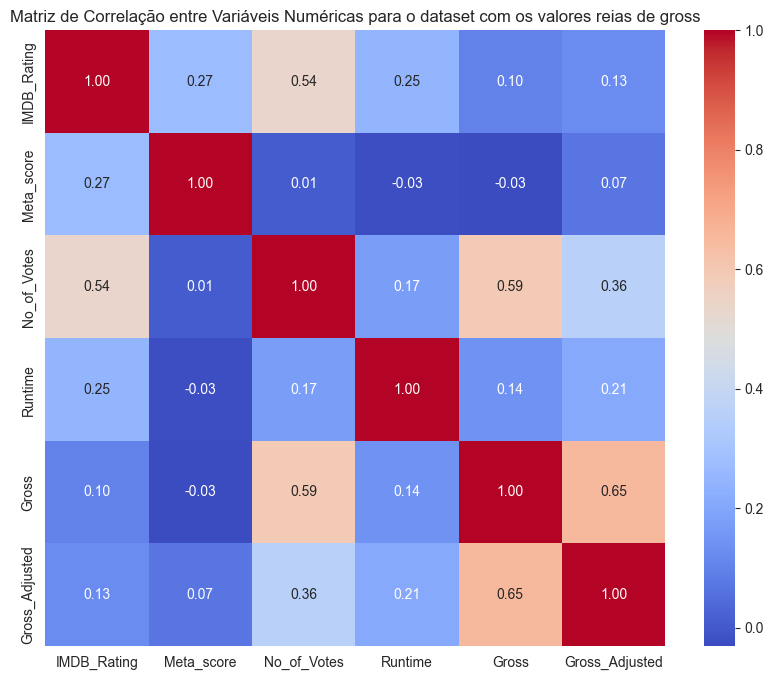

In [158]:
#Calcula a matriz de correlação
correlation_matrix = df_com_gross_real[numeric_cols].corr()

# Plota um heatmap para visualizar a correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis Numéricas para o dataset com os valores reias de gross')
plt.show()

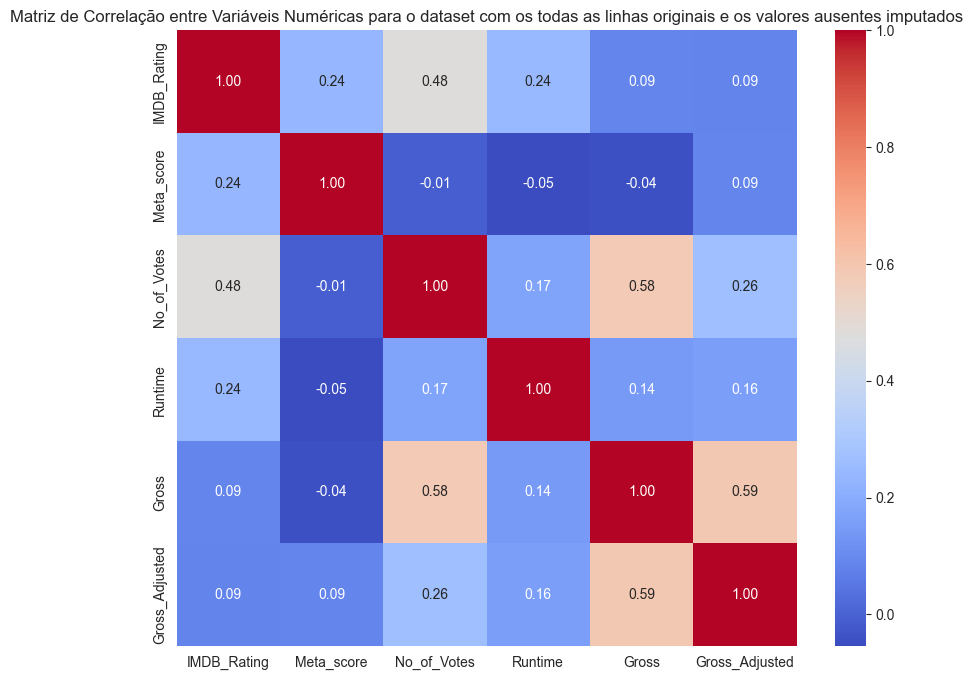

In [157]:
#Calcula a matriz de correlação
correlation_matrix = df_completo_futuro[numeric_cols].corr()

# Plota um heatmap para visualizar a correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis Numéricas para o dataset com os todas as linhas originais e os valores ausentes imputados')
plt.show()

Fica perceptivel que não há muita diferença entre usar o dataset sem os as linhas vazias de gross ou usar o dataset com todas as linha de gross, mas com os dados ausentes imputados.

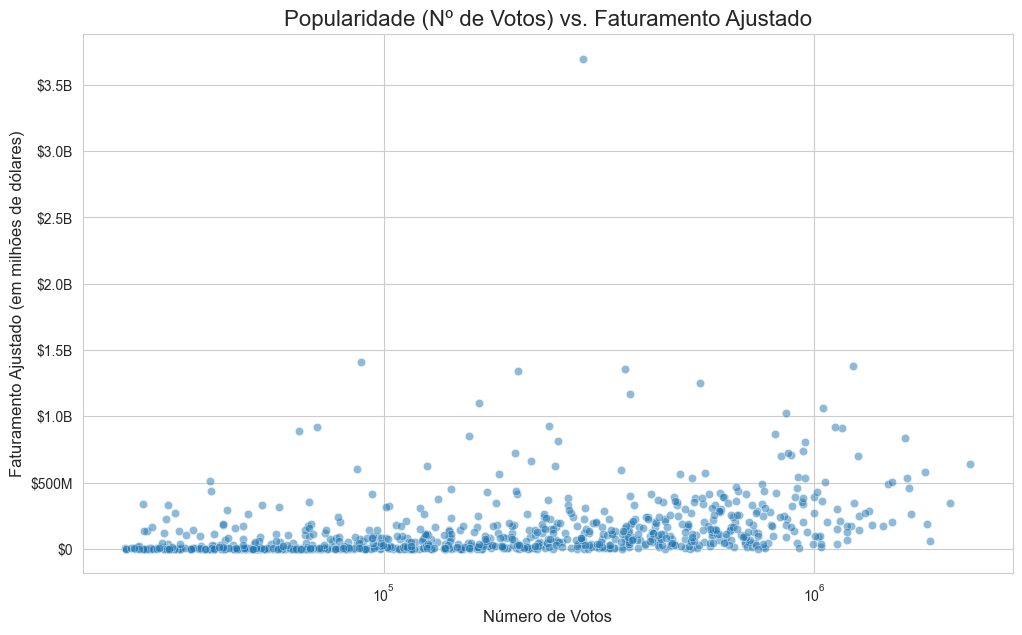

In [159]:
# Define a função para formatar o eixo Y em milhões
def millions_formatter(y, pos):
    return f'${y / 1e6:.0f}M'

plt.figure(figsize=(12, 7))
ax = sns.scatterplot(data=df_com_gross_real, x='No_of_Votes', y='Gross_Adjusted', alpha=0.5)
ax.set_title('Popularidade (Nº de Votos) vs. Faturamento Ajustado', fontsize=16)
ax.set_xlabel('Número de Votos', fontsize=12)
ax.set_ylabel('Faturamento Ajustado (em milhões de dólares)', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(formatador_dinamico))
ax.set_xscale('log') # Escala log no eixo X para melhor visualização da densidade
plt.grid(True)
plt.show()

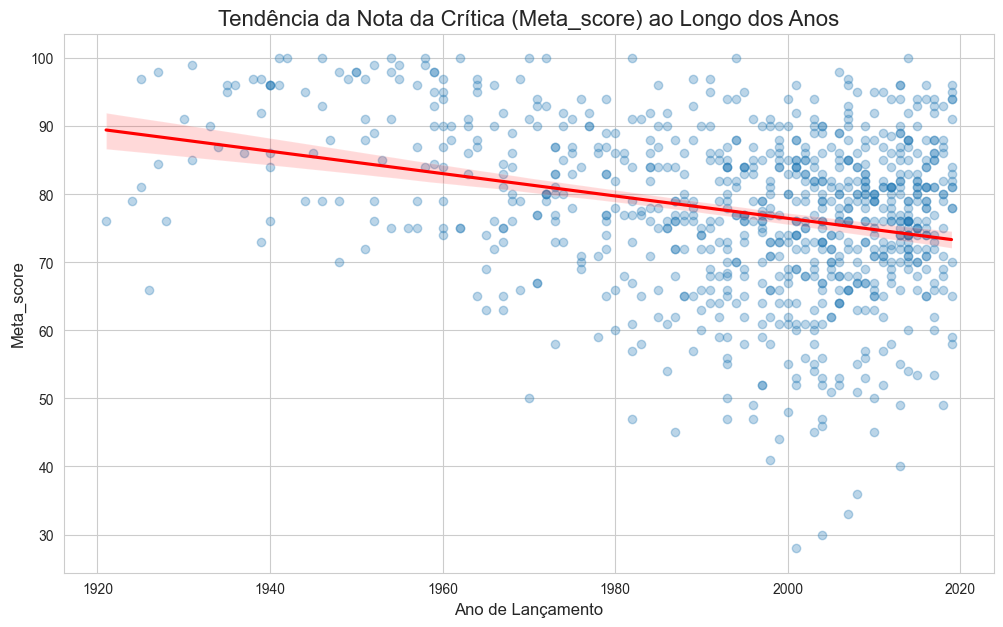

In [95]:
# Usamos o df_completo_imputado para ter a visão de todos os 1000 filmes
plt.figure(figsize=(12, 7))
ax = sns.regplot(data=df_com_gross_real, x='Released_Year', y='Meta_score',
                 scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
ax.set_title('Tendência da Nota da Crítica (Meta_score) ao Longo dos Anos', fontsize=16)
ax.set_xlabel('Ano de Lançamento', fontsize=12)
ax.set_ylabel('Meta_score', fontsize=12)
plt.grid(True)
plt.show()

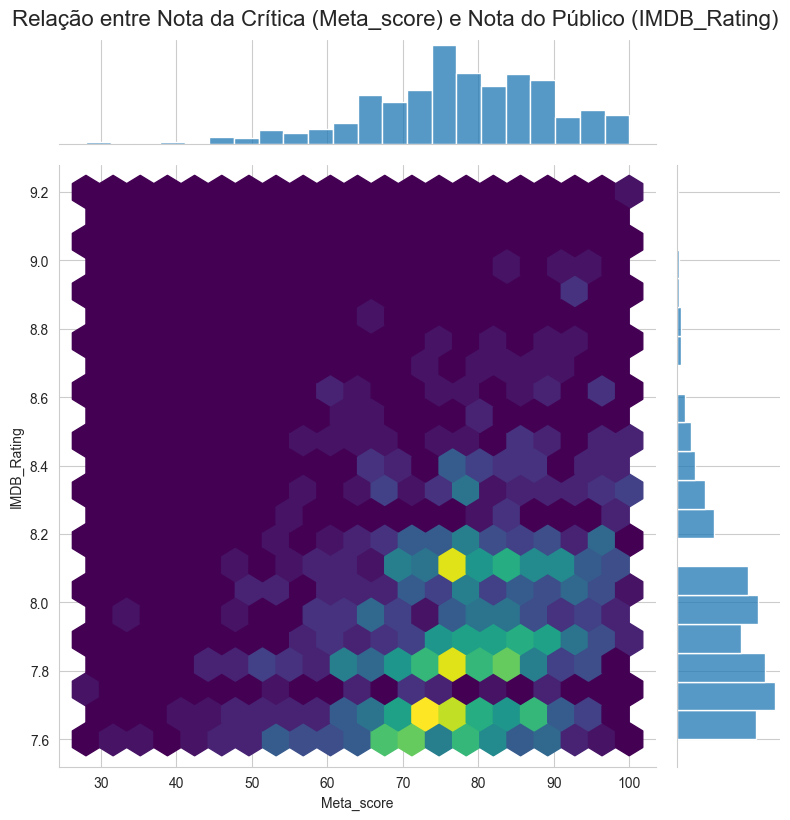

In [96]:
# Usamos o df_completo_imputado
sns.jointplot(data=df_com_gross_real, x='Meta_score', y='IMDB_Rating', kind='hex', height=8, cmap='viridis')
plt.suptitle('Relação entre Nota da Crítica (Meta_score) e Nota do Público (IMDB_Rating)', y=1.02, fontsize=16)
plt.show()

C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\855304079.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_completo_futuro, y='Certificate',


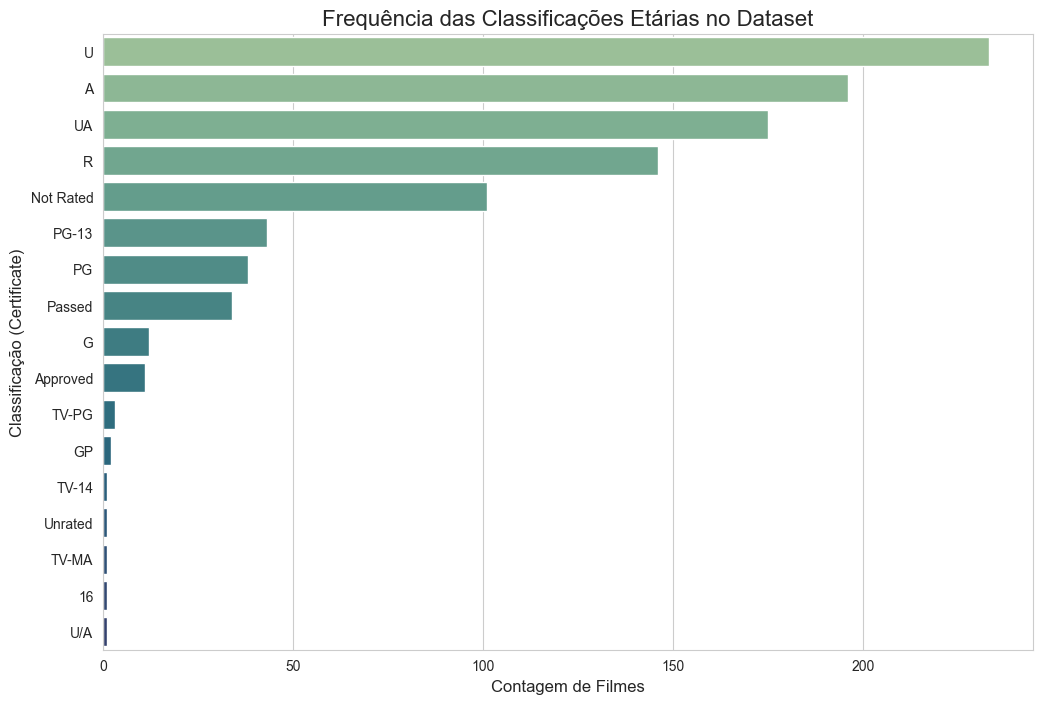

In [97]:
# Usando o df_completo_imputado para ter a visão de todos os filmes.
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=df_completo_futuro, y='Certificate', 
                   order=df_completo_futuro['Certificate'].value_counts().index, 
                   palette='crest')
ax.set_title('Frequência das Classificações Etárias no Dataset', fontsize=16)
ax.set_xlabel('Contagem de Filmes', fontsize=12)
ax.set_ylabel('Classificação (Certificate)', fontsize=12)
plt.show()

C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\4216065160.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_completo_futuro, y='Certificate', x='IMDB_Rating',


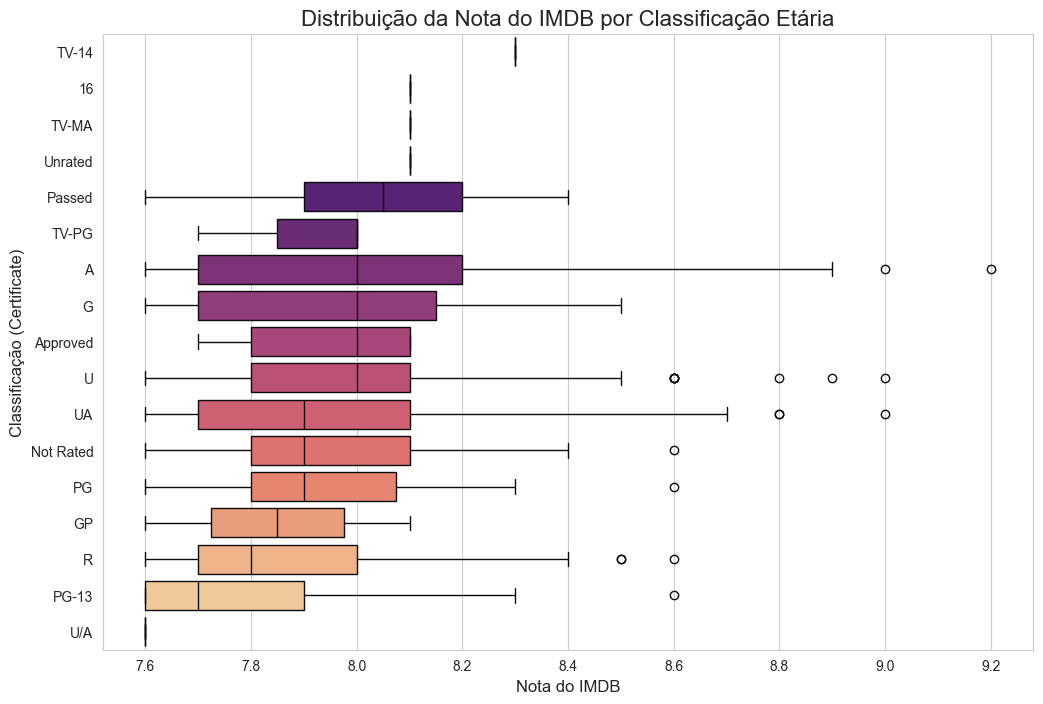

In [98]:
# Ordena as categorias pela mediana da nota para melhor visualização
order = df_completo_futuro.groupby('Certificate')['IMDB_Rating'].median().sort_values(ascending=False).index

plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df_completo_futuro, y='Certificate', x='IMDB_Rating', 
                 order=order, palette='magma')
ax.set_title('Distribuição da Nota do IMDB por Classificação Etária', fontsize=16)
ax.set_xlabel('Nota do IMDB', fontsize=12)
ax.set_ylabel('Classificação (Certificate)', fontsize=12)
plt.show()

C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\621269249.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_com_gross_real, y='Certificate', x='Gross_Adjusted',


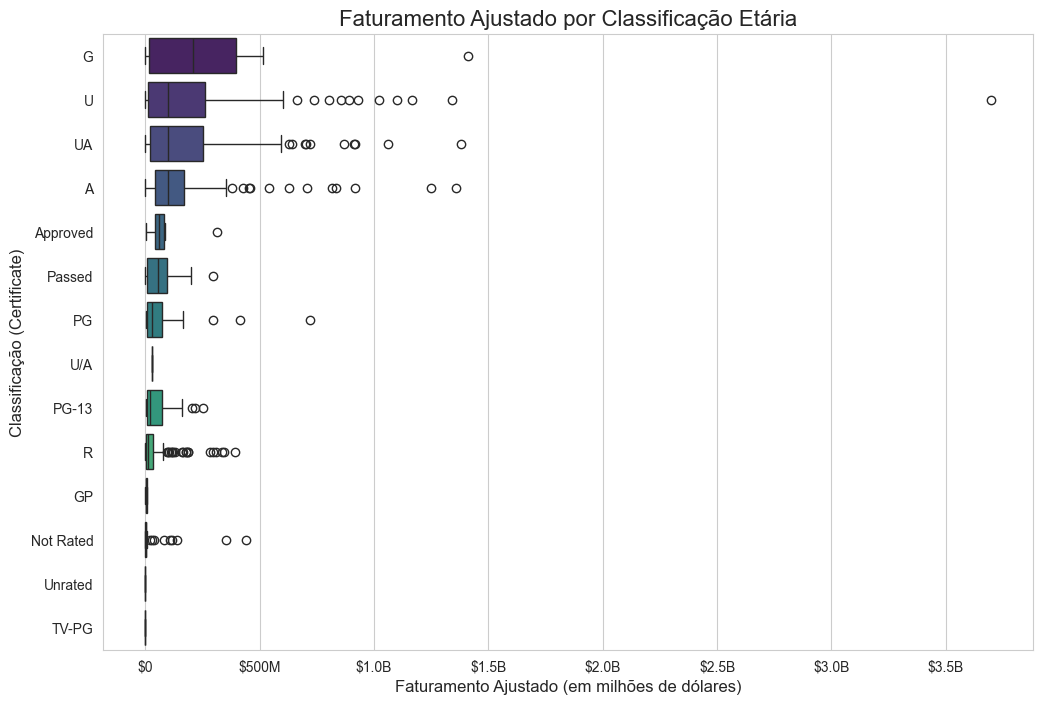

In [160]:
# Usando df_com_gross_real para análise financeira
# Ordena as categorias pela mediana do faturamento ajustado
order = df_com_gross_real.groupby('Certificate')['Gross_Adjusted'].median().sort_values(ascending=False).index

plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df_com_gross_real, y='Certificate', x='Gross_Adjusted', 
                 order=order, palette='viridis')

ax.xaxis.set_major_formatter(FuncFormatter(formatador_dinamico))

ax.set_title('Faturamento Ajustado por Classificação Etária', fontsize=16)
ax.set_xlabel('Faturamento Ajustado (em milhões de dólares)', fontsize=12)
ax.set_ylabel('Classificação (Certificate)', fontsize=12)
plt.show()

Distribuição das Variáveis Numéricas:


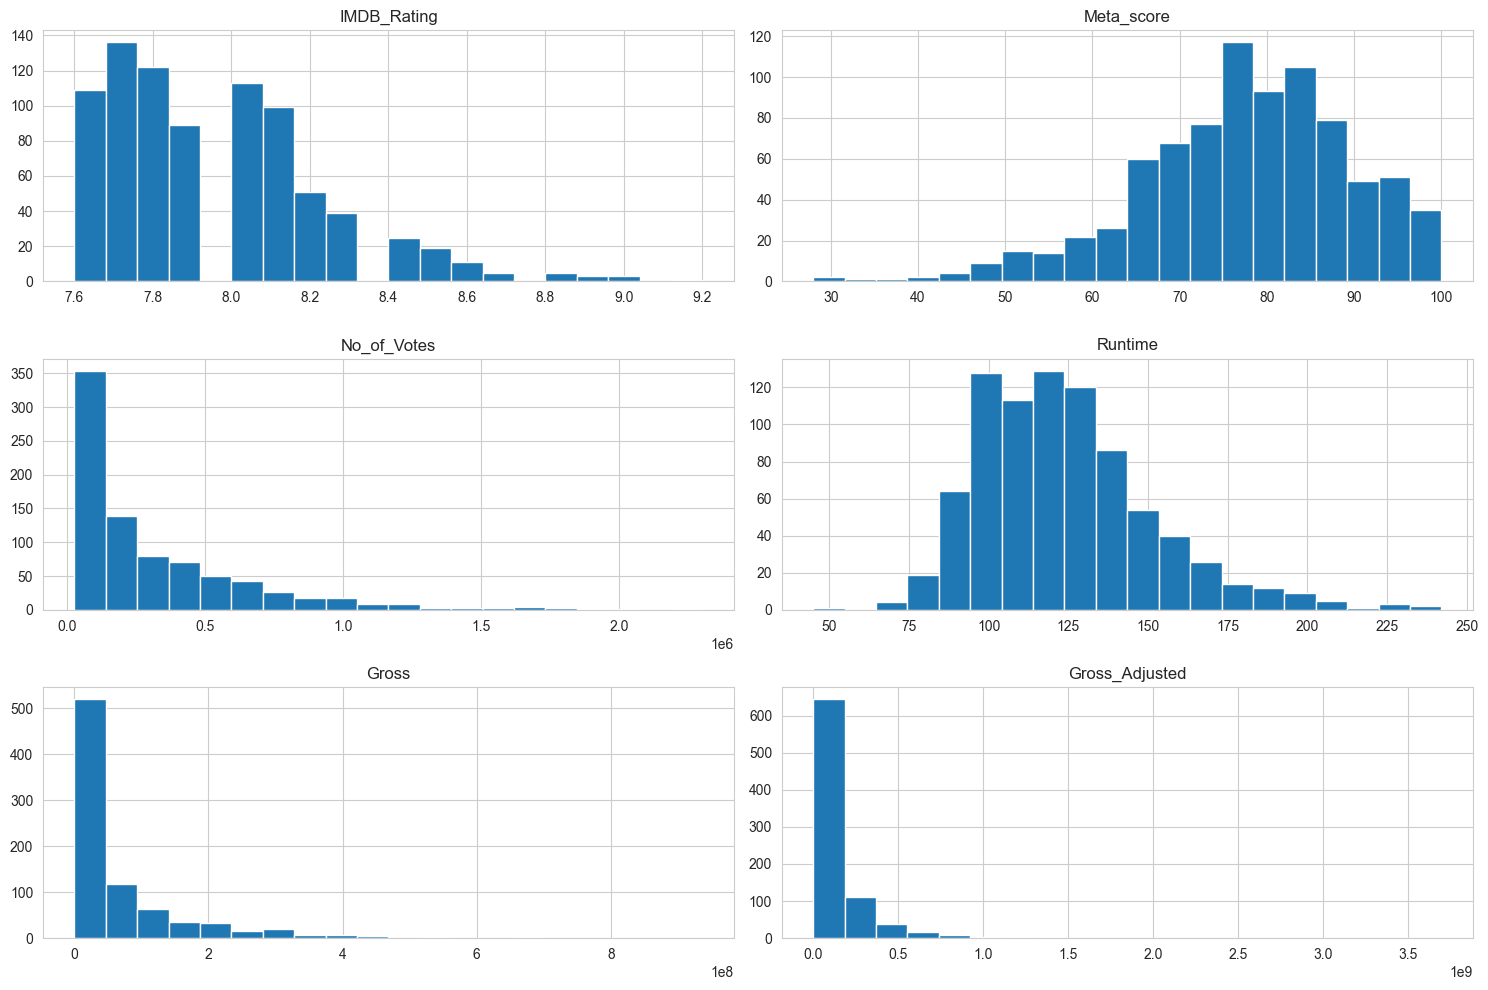

In [100]:
# Plota histogramas para visualizar a distribuição de cada variável numérica
print("Distribuição das Variáveis Numéricas:")
df_com_gross_real[numeric_cols].hist(bins=20, figsize=(15, 10))
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\3775704021.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres_by_gross.values, y=top_genres_by_gross.index, palette='plasma')


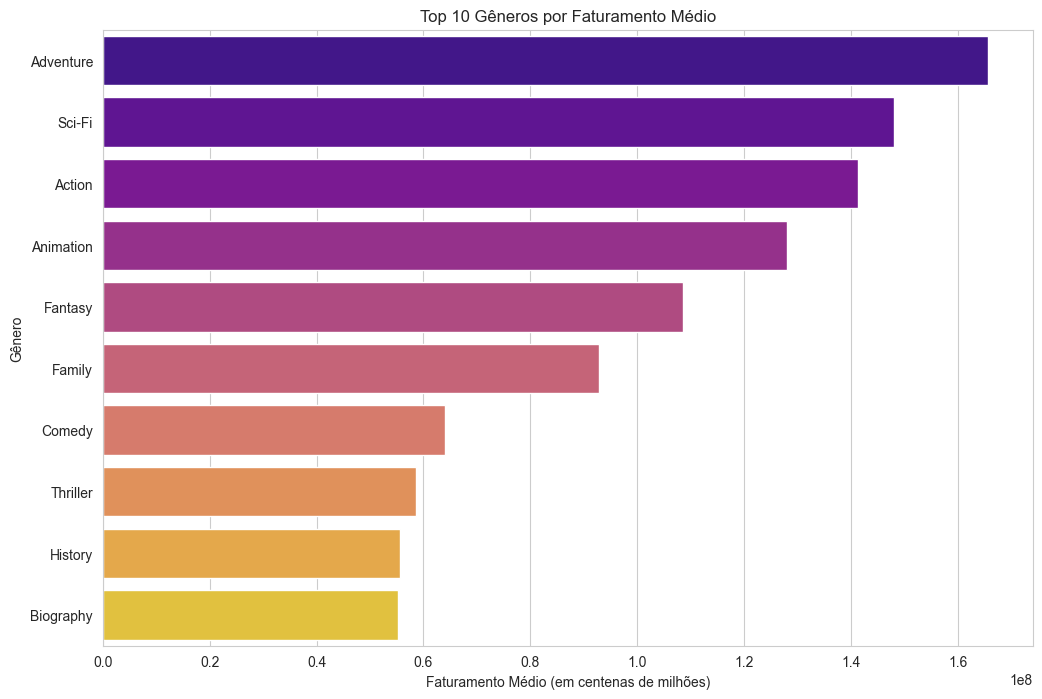

In [101]:
# Análise Bivariada: Relação entre Gênero e Faturamento/Nota
# Cria um DataFrame temporário com gêneros explodidos para análise
df_genre_exploded = df_com_gross_real.assign(Genre=df_com_gross_real['Genre'].str.split(', ')).explode('Genre')

# Faturamento médio por gênero (Top 10)
top_genres_by_gross = df_genre_exploded.groupby('Genre')['Gross'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_genres_by_gross.values, y=top_genres_by_gross.index, palette='plasma')
plt.title('Top 10 Gêneros por Faturamento Médio')
plt.xlabel('Faturamento Médio (em centenas de milhões)')
plt.ylabel('Gênero')
plt.show()

C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\804559279.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres_by_gross.values, y=top_genres_by_gross.index, palette='plasma')


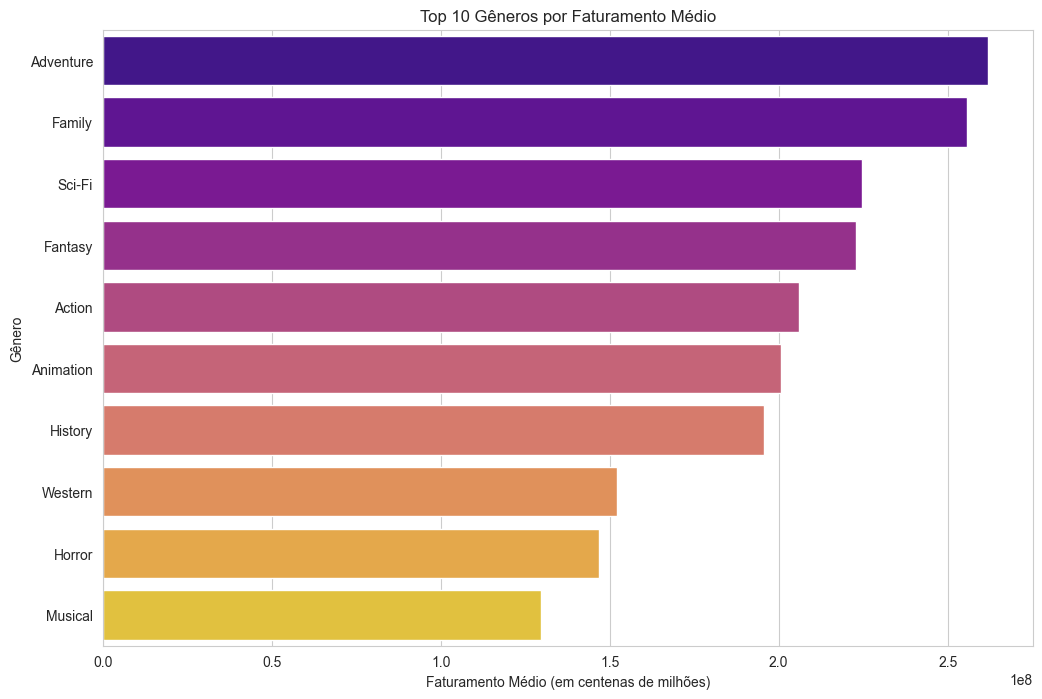

In [102]:
# Análise Bivariada: Relação entre Gênero e Faturamento/Nota
# Cria um DataFrame temporário com gêneros explodidos para análise
df_genre_exploded = df_com_gross_real.assign(Genre=df_com_gross_real['Genre'].str.split(', ')).explode('Genre')

# Faturamento médio por gênero (Top 10)
top_genres_by_gross = df_genre_exploded.groupby('Genre')['Gross_Adjusted'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_genres_by_gross.values, y=top_genres_by_gross.index, palette='plasma')
plt.title('Top 10 Gêneros por Faturamento Médio')
plt.xlabel('Faturamento Médio (em centenas de milhões)')
plt.ylabel('Gênero')
plt.show()

C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\3218848127.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_top_genres_gross, y='Genre', x='Gross_Adjusted', order=genre_order, palette='viridis')


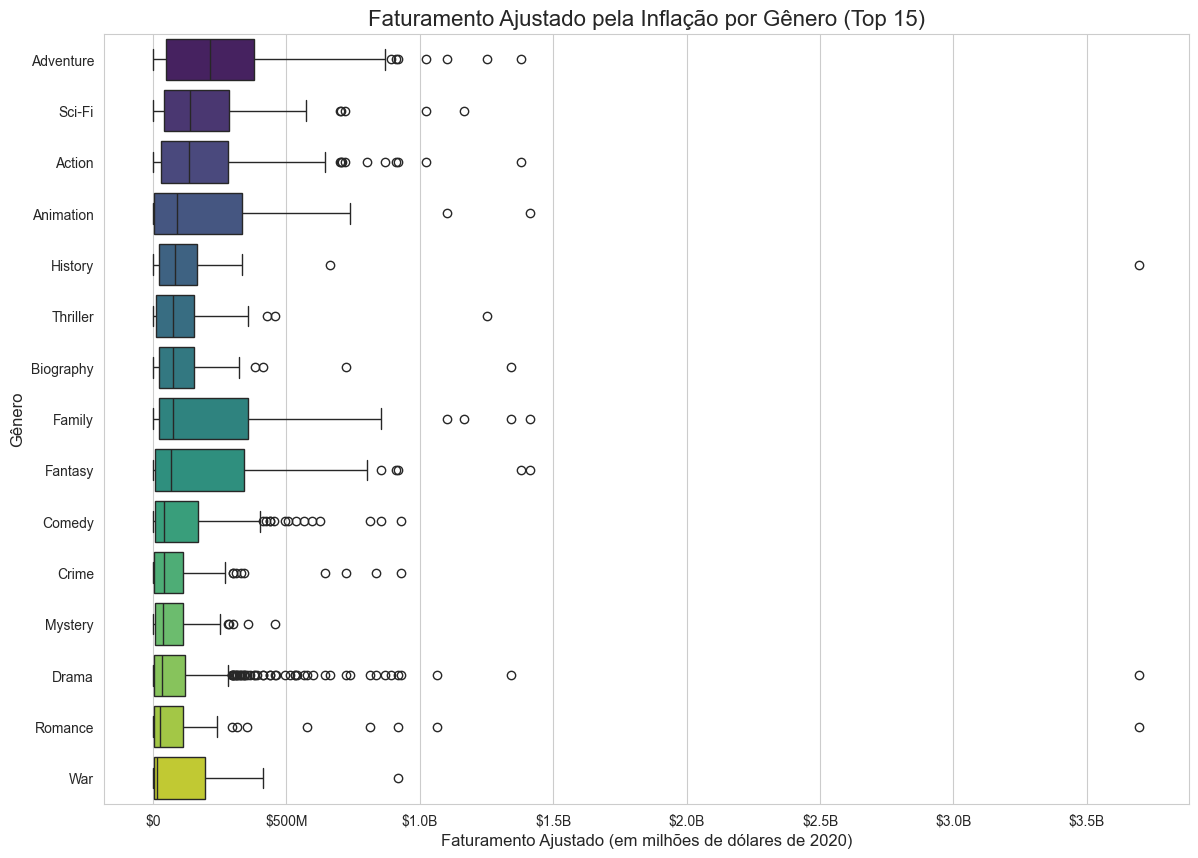

In [161]:
# Um grafico que mostra qual gênero é mais lucrativo 
df_exploded_gross = df_com_gross_real.assign(Genre=df_com_gross_real['Genre'].str.split(', ')).explode('Genre')
top_genres = df_exploded_gross['Genre'].value_counts().nlargest(15).index
df_top_genres_gross = df_exploded_gross[df_exploded_gross['Genre'].isin(top_genres)]
genre_order = df_top_genres_gross.groupby('Genre')['Gross_Adjusted'].median().sort_values(ascending=False).index

pd.options.display.float_format = '{:,.2f}'.format

plt.figure(figsize=(14, 10))
ax = sns.boxplot(data=df_top_genres_gross, y='Genre', x='Gross_Adjusted', order=genre_order, palette='viridis')

ax.xaxis.set_major_formatter(FuncFormatter(formatador_dinamico))
ax.set_title('Faturamento Ajustado pela Inflação por Gênero (Top 15)', fontsize=16)
ax.set_xlabel('Faturamento Ajustado (em milhões de dólares de 2020)', fontsize=12)
ax.set_ylabel('Gênero', fontsize=12)
plt.show()


In [104]:

# Configura o formato de exibição para facilitar a leitura
pd.options.display.float_format = '{:,.2f}'.format

# Ordena o DataFrame pela coluna 'Gross_Adjusted' em ordem decrescente e pega os 10 primeiros
top_10_faturamento = df_com_gross_real.sort_values(by='Gross_Adjusted', ascending=False).head(10)

print("Top 10 Filmes por Faturamento Ajustado pela Inflação:")
display(top_10_faturamento[['Series_Title', 'Released_Year', 'Gross', 'Gross_Adjusted']])

Top 10 Filmes por Faturamento Ajustado pela Inflação:


,Series_Title,Released_Year,Gross,Gross_Adjusted
255,Gone with the Wind,1939,"198,676,459.00","3,697,041,544.13"
720,Fantasia,1940,"76,408,097.00","1,411,678,909.75"
26,Star Wars,1977,"322,740,140.00","1,378,172,729.22"
347,The Exorcist,1973,"232,906,145.00","1,357,628,628.63"
355,The Sound of Music,1965,"163,214,286.00","1,340,651,037.60"
343,Jaws,1975,"260,000,000.00","1,250,372,932.80"
568,E.T. the Extra-Terrestrial,1982,"435,110,554.00","1,166,958,239.48"
827,The Jungle Book,1967,"141,843,612.00","1,100,495,949.22"
535,Titanic,1997,"659,325,379.00","1,063,071,979.35"
387,Star Wars: Episode VII - The Force Awakens,2015,"936,662,225.00","1,022,790,108.83"


C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\199672845.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=top_10_directors.values, y=top_10_directors.index, palette='mako')


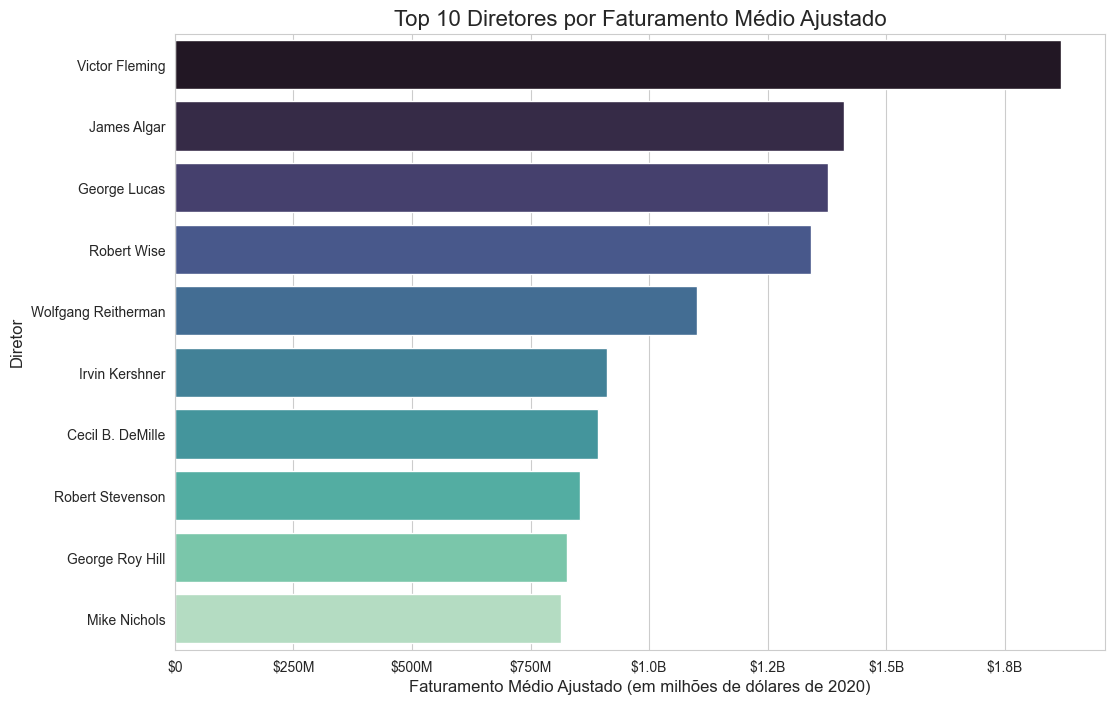

In [162]:
# Identificar quais diretores estão associados a um maior retorno financeiro.
# Usamos df_com_gross_real para garantir que a análise seja baseada em dados reais de faturamento.


# Calcula a média de faturamento ajustado por diretor e pega o top 10
top_10_directors = df_com_gross_real.groupby('Director')['Gross_Adjusted'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
ax1 = sns.barplot(x=top_10_directors.values, y=top_10_directors.index, palette='mako')
ax1.set_title('Top 10 Diretores por Faturamento Médio Ajustado', fontsize=16)
ax1.set_xlabel('Faturamento Médio Ajustado (em milhões de dólares de 2020)', fontsize=12)
ax1.set_ylabel('Diretor', fontsize=12)

ax1.xaxis.set_major_formatter(FuncFormatter(formatador_dinamico))
plt.show()


Gerando Visualização 2: Top 10 Atores por Faturamento Médio...


C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\3659583872.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=top_10_stars.values, y=top_10_stars.index, palette='rocket')


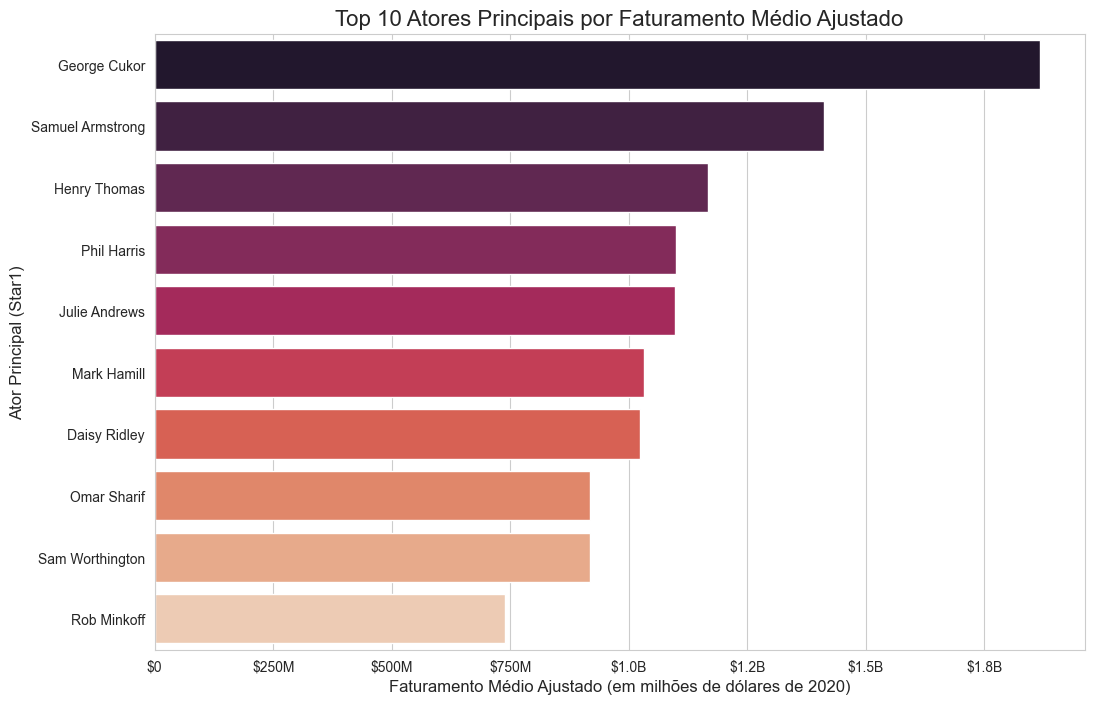

In [163]:
# Identificar quais atores principais (Star1) estão associados a filmes de maior bilheteria.

# Calcula a média de faturamento ajustado por ator e pega o top 10
top_10_stars = df_com_gross_real.groupby('Star1')['Gross_Adjusted'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
ax2 = sns.barplot(x=top_10_stars.values, y=top_10_stars.index, palette='rocket')
ax2.set_title('Top 10 Atores Principais por Faturamento Médio Ajustado', fontsize=16)
ax2.set_xlabel('Faturamento Médio Ajustado (em milhões de dólares de 2020)', fontsize=12)
ax2.set_ylabel('Ator Principal (Star1)', fontsize=12)
ax2.xaxis.set_major_formatter(FuncFormatter(formatador_dinamico))
plt.show()


Gerando Visualização 3: Aclamação da Crítica vs. Popularidade...


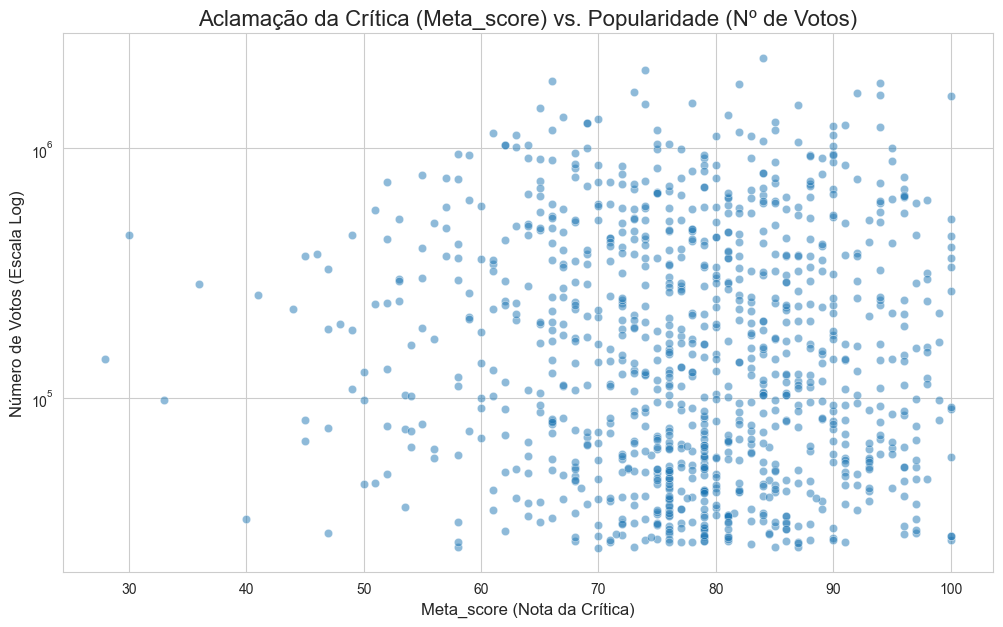

In [107]:
# Entender se filmes aclamados pela crítica (alto Meta_score) são
# também os mais populares (alto No_of_Votes).

plt.figure(figsize=(12, 7))
ax3 = sns.scatterplot(data=df_completo_futuro, x='Meta_score', y='No_of_Votes', alpha=0.5)
ax3.set_yscale('log') # Usar escala logarítmica no eixo Y para melhor visualização da densidade
ax3.set_title('Aclamação da Crítica (Meta_score) vs. Popularidade (Nº de Votos)', fontsize=16)
ax3.set_xlabel('Meta_score (Nota da Crítica)', fontsize=12)
ax3.set_ylabel('Número de Votos (Escala Log)', fontsize=12)
plt.grid(True)
plt.show()


Gerando Visualização 4: Evolução da Duração Média dos Filmes...


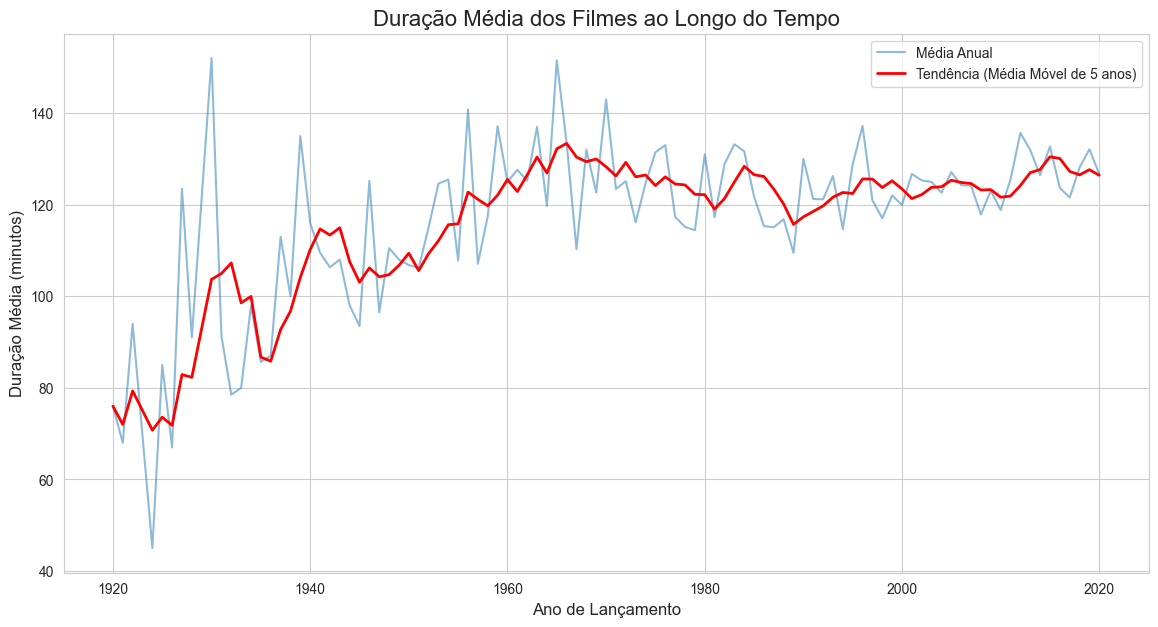

In [108]:
# Verificar se existe uma tendência de aumento ou diminuição na
# duração dos filmes ao longo dos anos.

# Calcula a duração média por ano
runtime_over_time = df_completo_futuro.groupby('Released_Year')['Runtime'].mean().reset_index()
# Adiciona uma média móvel para suavizar a linha e identificar a tendência
runtime_over_time['rolling_avg'] = runtime_over_time['Runtime'].rolling(window=5, min_periods=1).mean()

plt.figure(figsize=(14, 7))
ax4 = sns.lineplot(data=runtime_over_time, x='Released_Year', y='Runtime', label='Média Anual', alpha=0.5)
sns.lineplot(data=runtime_over_time, x='Released_Year', y='rolling_avg', label='Tendência (Média Móvel de 5 anos)', color='red', lw=2, ax=ax4)
ax4.set_title('Duração Média dos Filmes ao Longo do Tempo', fontsize=16)
ax4.set_xlabel('Ano de Lançamento', fontsize=12)
ax4.set_ylabel('Duração Média (minutos)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Top 10 Gêneros Mais Comuns:
Genre
Drama        596
Comedy       191
Crime        171
Adventure    170
Action       156
Thriller     110
Romance      107
Biography     96
Mystery       84
Animation     67
Name: count, dtype: int64


C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\673120289.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.head(10).values, y=genre_counts.head(10).index, palette='viridis')


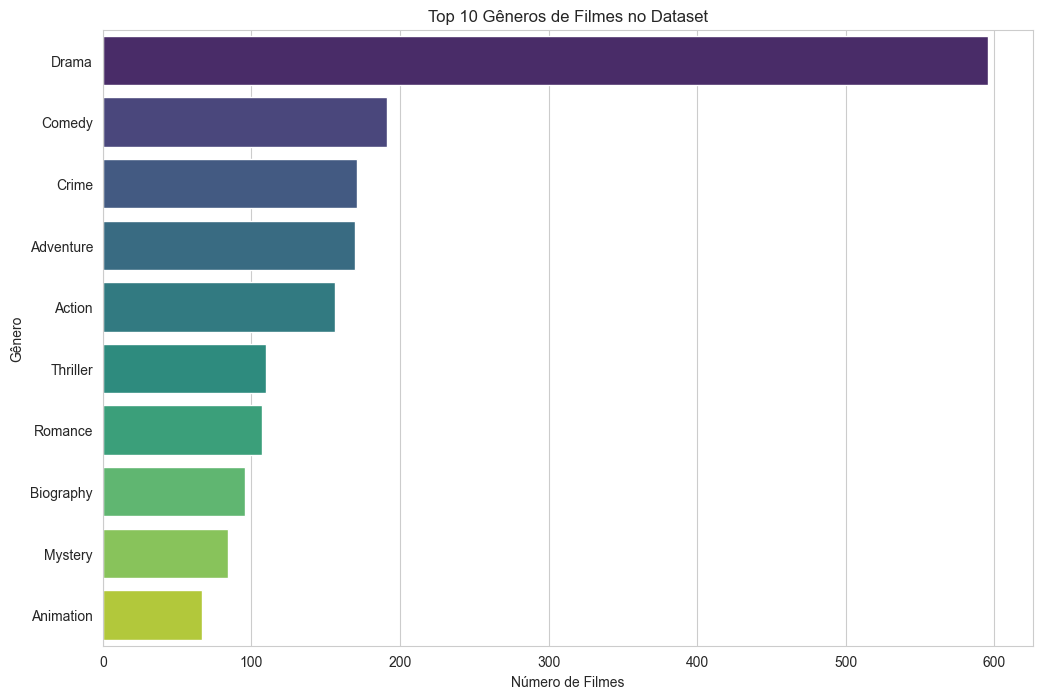

In [109]:
# Como um filme pode ter múltiplos gêneros, separamos e contamos cada um
genre_counts = df_com_gross_real['Genre'].str.split(', ').explode().value_counts()

print("Top 10 Gêneros Mais Comuns:")
print(genre_counts.head(10))

# Visualiza a contagem dos 10 gêneros mais comuns
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.head(10).values, y=genre_counts.head(10).index, palette='viridis')
plt.title('Top 10 Gêneros de Filmes no Dataset')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.show()

Top 10 Gêneros Mais Comuns:
Genre
Drama        723
Comedy       233
Crime        209
Adventure    196
Action       189
Thriller     137
Romance      125
Biography    109
Mystery       99
Animation     82
Name: count, dtype: int64


C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\3837900877.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.head(10).values, y=genre_counts.head(10).index, palette='viridis')


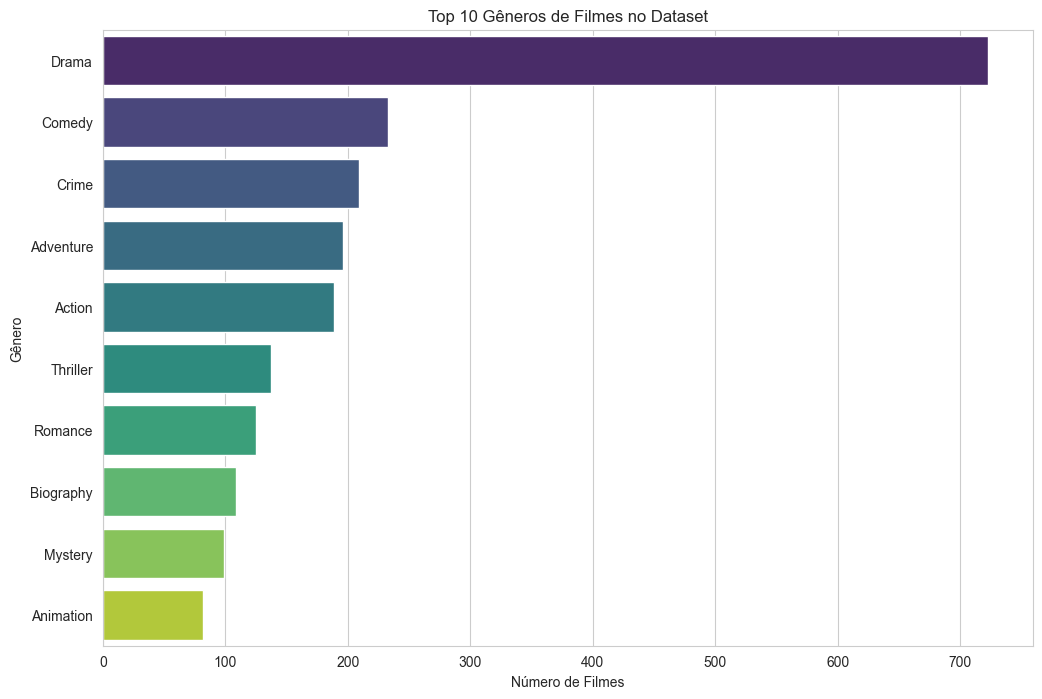

In [110]:
# Como um filme pode ter múltiplos gêneros, separamos e contamos cada um
genre_counts = df_completo_futuro['Genre'].str.split(', ').explode().value_counts()

print("Top 10 Gêneros Mais Comuns:")
print(genre_counts.head(10))

# Visualiza a contagem dos 10 gêneros mais comuns
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.head(10).values, y=genre_counts.head(10).index, palette='viridis')
plt.title('Top 10 Gêneros de Filmes no Dataset')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.show()

# Perguntas do Desafio

### A): Qual filme você recomendaria para uma pessoa que você não conhece?
Metodologia: A melhor recomendação para um desconhecido é um "porto seguro": um filme que seja aclamado pela crítica (alta nota) e extremamente popular (muitos votos).
Isso minimiza a chance de a pessoa não gostar.

In [113]:
# Filtra por filmes com nota muito alta e um grande número de votos
safe_bet_filter = (df_completo_futuro['IMDB_Rating'] >= 8.8) & (df_completo_futuro['No_of_Votes'] > 1500000)
recomendacao_df = df_completo_futuro[safe_bet_filter].sort_values(by='No_of_Votes', ascending=False)

# Pega o filme no topo da lista
filme_recomendado = recomendacao_df.iloc[0]

print("Filme recomendado:")
print(filme_recomendado[['Series_Title', 'IMDB_Rating', 'No_of_Votes', 'Genre']])


Filme recomendado:
Series_Title         The Dark Knight
IMDB_Rating                     9.00
No_of_Votes                  2303232
Genre           Action, Crime, Drama
Name: 1, dtype: object


## B): Quais são os principais fatores de faturamento?


In [114]:
# Correlação com outras variáveis
# Usamos df_com_gross_real para uma análise financeira precisa
correlacao_faturamento = df_com_gross_real.select_dtypes(include=np.number).corr()['Gross_Adjusted'].sort_values(ascending=False)
print("\n Correlação com outras variáveis:")
print(correlacao_faturamento)

# Gênero
top_generos_faturamento = df_com_gross_real.assign(Genre=df_com_gross_real['Genre'].str.split(', ')).explode('Genre')\
                                           .groupby('Genre')['Gross_Adjusted'].median().sort_values(ascending=False)
print("\n Mediana de Faturamento Ajustado por Gênero (Top 5):")
print(top_generos_faturamento.head())

# Classificação Etária
faturamento_por_classificacao = df_com_gross_real.groupby('Certificate_Harmonized')['Gross_Adjusted'].median().sort_values(ascending=False)
print("\nFator 3: Mediana de Faturamento por Classificação Harmonizada:")
print(faturamento_por_classificacao)


 Correlação com outras variáveis:
Gross_Adjusted    1.00
Gross             0.65
No_of_Votes       0.36
Runtime           0.21
IMDB_Rating       0.13
Meta_score        0.07
Released_Year    -0.14
Year             -0.14
CPI              -0.17
Name: Gross_Adjusted, dtype: float64

 Mediana de Faturamento Ajustado por Gênero (Top 5):
Genre
Adventure   214,250,858.19
Sci-Fi      139,512,237.99
Action      132,880,141.10
Western     116,142,513.82
Animation    90,823,106.32
Name: Gross_Adjusted, dtype: float64

Fator 3: Mediana de Faturamento por Classificação Harmonizada:
Certificate_Harmonized
Livre              96,701,414.59
Acompanhado        61,192,929.92
Adulto             46,255,023.62
Não Classificado    3,670,049.96
Name: Gross_Adjusted, dtype: float64


## C.1) Quais insights podem ser tirados com a coluna Overview?

--- ANÁLISE APROFUNDADA DA COLUNA 'OVERVIEW' ---

--- Insight 1: Gerando Nuvem de Palavras por Gênero ---


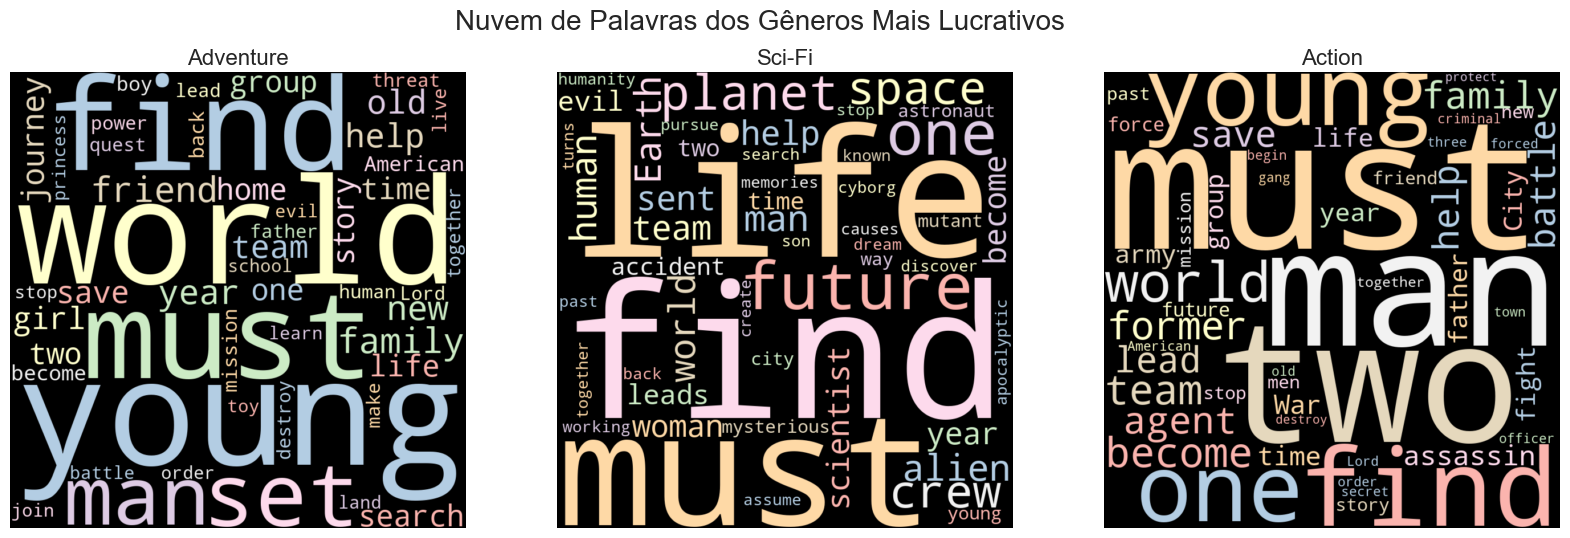


--- Insight 2: Analisando o Sentimento dos Resumos ---


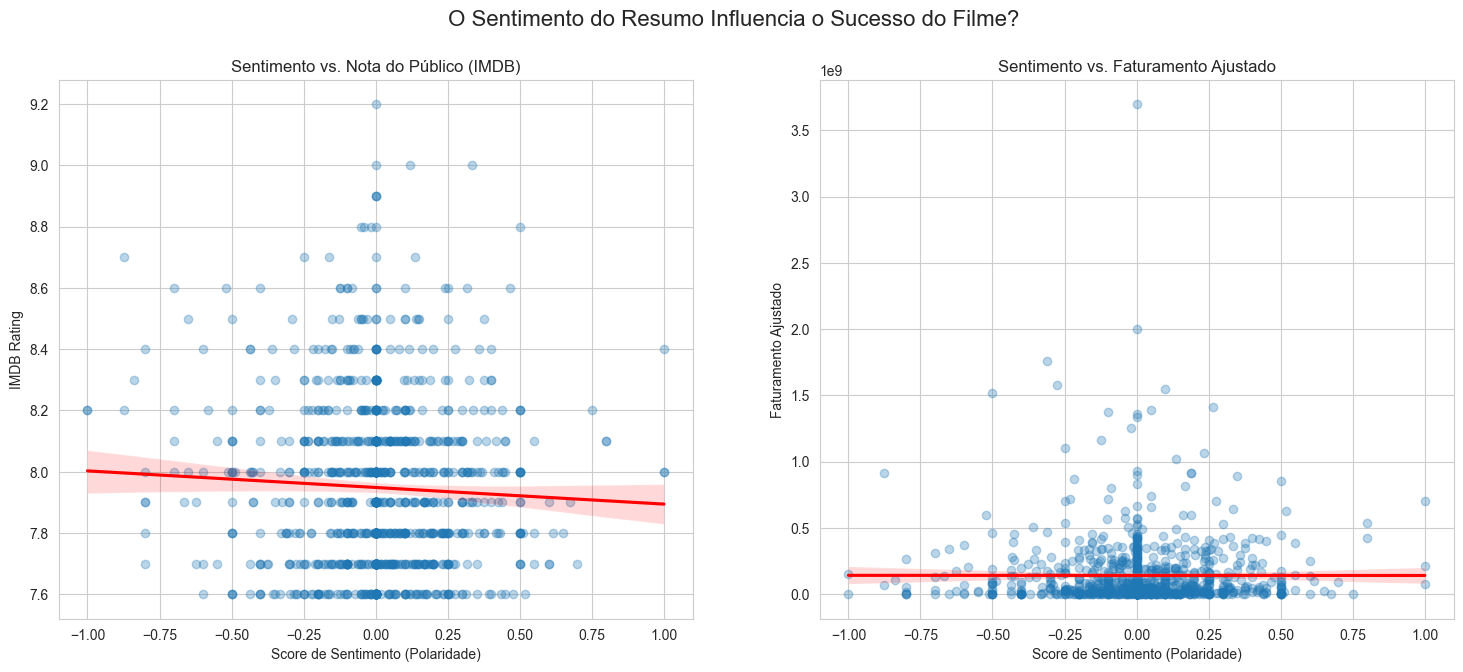


--- Insight 3: Analisando a Complexidade da Linguagem por Gênero ---


C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\598264429.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_top_genres_full, y='Genre', x='avg_word_length', order=order, palette='coolwarm')


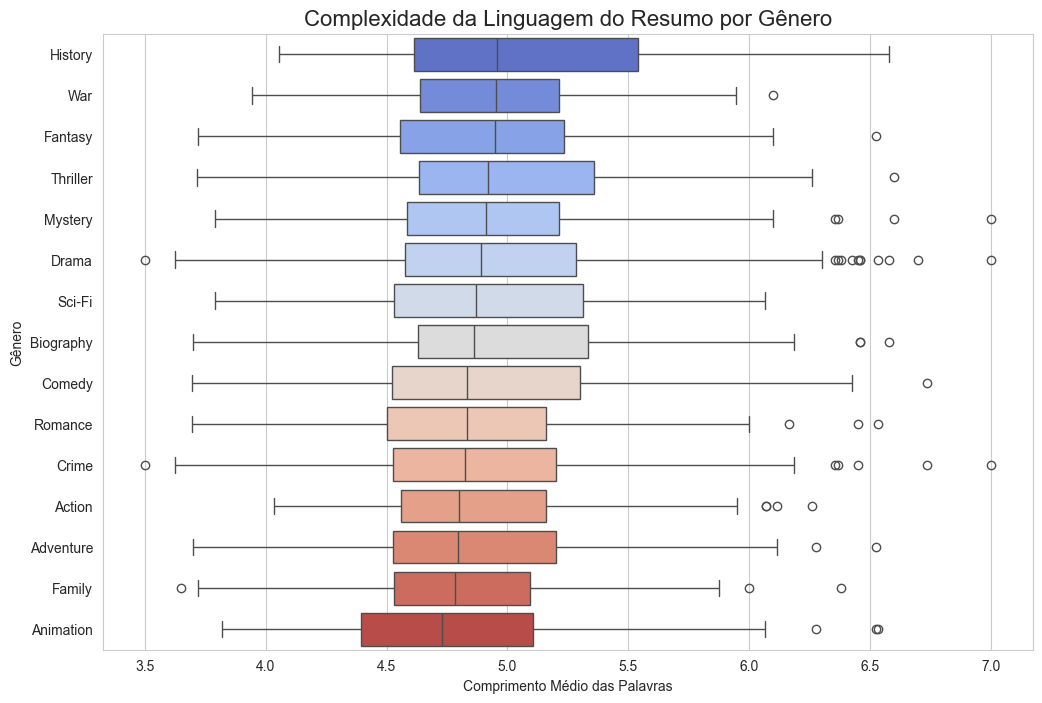

In [120]:
# Comparação entre os temas mais rentaveis


df_exploded_gross = df_com_gross_real.assign(Genre=df_com_gross_real['Genre'].str.split(', ')).explode('Genre')
top_3_genres = df_exploded_gross.groupby('Genre')['Gross_Adjusted'].median().nlargest(3).index

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Nuvem de Palavras dos Gêneros Mais Lucrativos', fontsize=20)

for i, genre in enumerate(top_3_genres):
    # Filtra os filmes do gênero específico (adicionado na=False para segurança)
    text = " ".join(overview for overview in df_completo_futuro[df_completo_futuro['Genre'].str.contains(genre, na=False)].Overview)
    
    # Gera a nuvem de palavras
    wordcloud = WordCloud(max_words=50, background_color="black", colormap='Pastel1', width=800, height=800).generate(text)
    
    # Plota a nuvem no subplot correspondente
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(genre, fontsize=16)
    axes[i].axis("off")

plt.show()


# Sentimentos e sua  relação com o sucesso 
if 'sentiment_score' not in df_completo_futuro.columns:
    df_completo_futuro['sentiment_score'] = df_completo_futuro['Overview'].apply(lambda x: TextBlob(x).sentiment.polarity)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('O Sentimento do Resumo Influencia o Sucesso do Filme?', fontsize=16)

sns.regplot(data=df_completo_futuro, x='sentiment_score', y='IMDB_Rating', ax=axes[0],
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
axes[0].set_title('Sentimento vs. Nota do Público (IMDB)')
axes[0].set_xlabel('Score de Sentimento (Polaridade)')
axes[0].set_ylabel('IMDB Rating')

sns.regplot(data=df_completo_futuro, x='sentiment_score', y='Gross_Adjusted', ax=axes[1],
            scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
axes[1].set_title('Sentimento vs. Faturamento Ajustado')
axes[1].set_xlabel('Score de Sentimento (Polaridade)')
axes[1].set_ylabel('Faturamento Ajustado')
plt.show()



# Complexidade da linguagem por genero 

df_completo_futuro['avg_word_length'] = df_completo_futuro['Overview'].apply(lambda x: np.mean([len(word) for word in x.split()]))

df_exploded_full = df_completo_futuro.assign(Genre=df_completo_futuro['Genre'].str.split(', ')).explode('Genre')
top_15_genres = df_exploded_full['Genre'].value_counts().nlargest(15).index
df_top_genres_full = df_exploded_full[df_exploded_full['Genre'].isin(top_15_genres)]

order = df_top_genres_full.groupby('Genre')['avg_word_length'].median().sort_values(ascending=False).index

plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df_top_genres_full, y='Genre', x='avg_word_length', order=order, palette='coolwarm')
ax.set_title('Complexidade da Linguagem do Resumo por Gênero', fontsize=16)
ax.set_xlabel('Comprimento Médio das Palavras')
ax.set_ylabel('Gênero')
plt.show()

C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\1289943086.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=top_bigrams_df, palette='cividis')


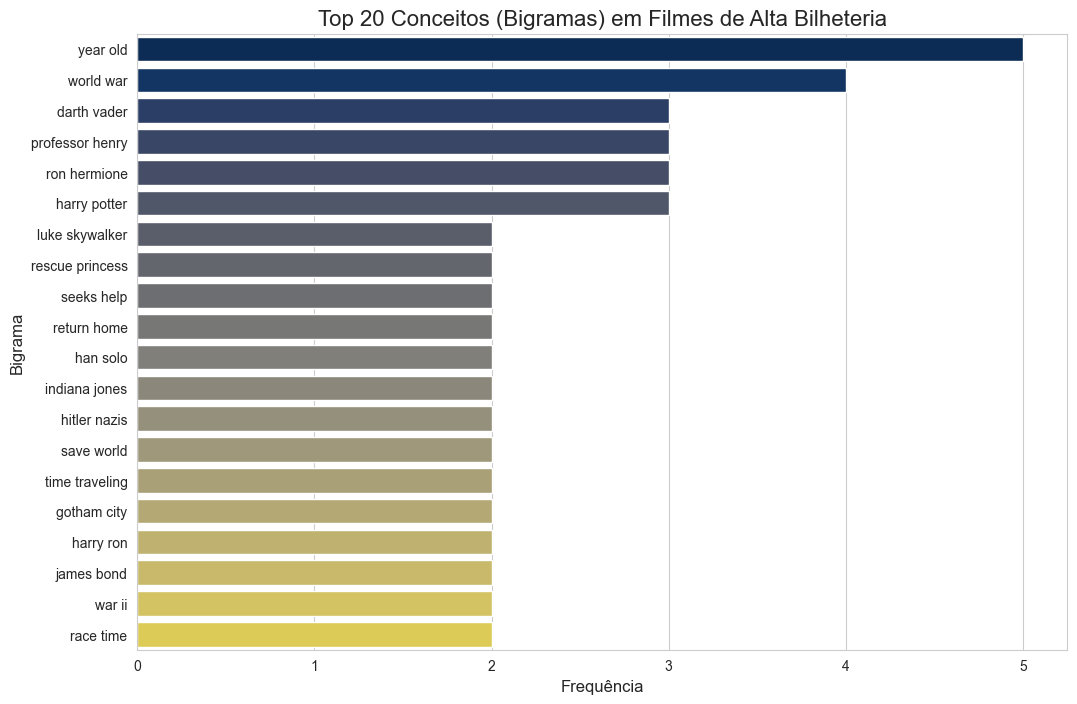

In [121]:
from sklearn.feature_extraction.text import CountVectorizer

# Usando os 100 filmes de maior faturamento do df_com_gross_real
top_100_gross_movies = df_com_gross_real.sort_values(by='Gross_Adjusted', ascending=False).head(100)
overviews = top_100_gross_movies['Overview']

# Configura o vetorizador para encontrar bigramas (pares de palavras) e remover stopwords
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
X = vectorizer.fit_transform(overviews)

# Soma as ocorrências de cada bigrama
bigram_counts = X.sum(axis=0)
words_freq = [(word, bigram_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# Prepara os dados para o gráfico
top_bigrams_df = pd.DataFrame(words_freq, columns=['bigram', 'count'])

# Visualização
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=top_bigrams_df, palette='cividis')
plt.title('Top 20 Conceitos (Bigramas) em Filmes de Alta Bilheteria', fontsize=16)
plt.xlabel('Frequência', fontsize=12)
plt.ylabel('Bigrama', fontsize=12)
plt.show()

In [156]:
from sklearn.decomposition import LatentDirichletAllocation

# Usaremos o mesmo vetorizador de contagem, mas para palavras únicas
vectorizer_lda = CountVectorizer(stop_words='english', max_features=1000)
X_lda = vectorizer_lda.fit_transform(df_completo_futuro['Overview'])

# Cria e treina o modelo LDA para encontrar 5 tópicos
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_lda)

# Função para exibir os tópicos
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Tópico #{topic_idx+1}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("\nOs 5 Principais Tópicos Temáticos Ocultos nos Resumos dos Filmes:")
print_top_words(lda, vectorizer_lda.get_feature_names_out(), 10)



Os 5 Principais Tópicos Temáticos Ocultos nos Resumos dos Filmes:
Tópico #1: new young life old man love friends death murder boy
Tópico #2: man young father school high old life story girl police
Tópico #3: young new woman city life man story love son york
Tópico #4: war world life family american help love man ii finds
Tópico #5: world wife small time new officer story help war team


Iniciando Análise de Relação entre Tópicos, Notas e Faturamento 

As palavras mais importantes para cada Tópico descoberto:
Tópico #0: man | life | small | american | war | battle | time | leads | city | world
Tópico #1: father | life | son | young | years | mother | daughter | story | woman | help
Tópico #2: man | young | life | love | finds | girl | world | people | takes | woman
Tópico #3: new | young | old | year | family | woman | friends | world | york | friend
Tópico #4: war | world | team | high | ii | school | german | time | day | detective

Cada filme foi associado a um tópico temático.


C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\3162313594.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_completo_futuro, y='Topic', x='IMDB_Rating', ax=axes[0], order=order_imdb, palette='plasma')
C:\Users\Rodrigo Moura\AppData\Local\Temp\ipykernel_11624\3162313594.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_completo_futuro, y='Topic', x='Gross_Adjusted', ax=axes[1], order=order_gross, palette='viridis')


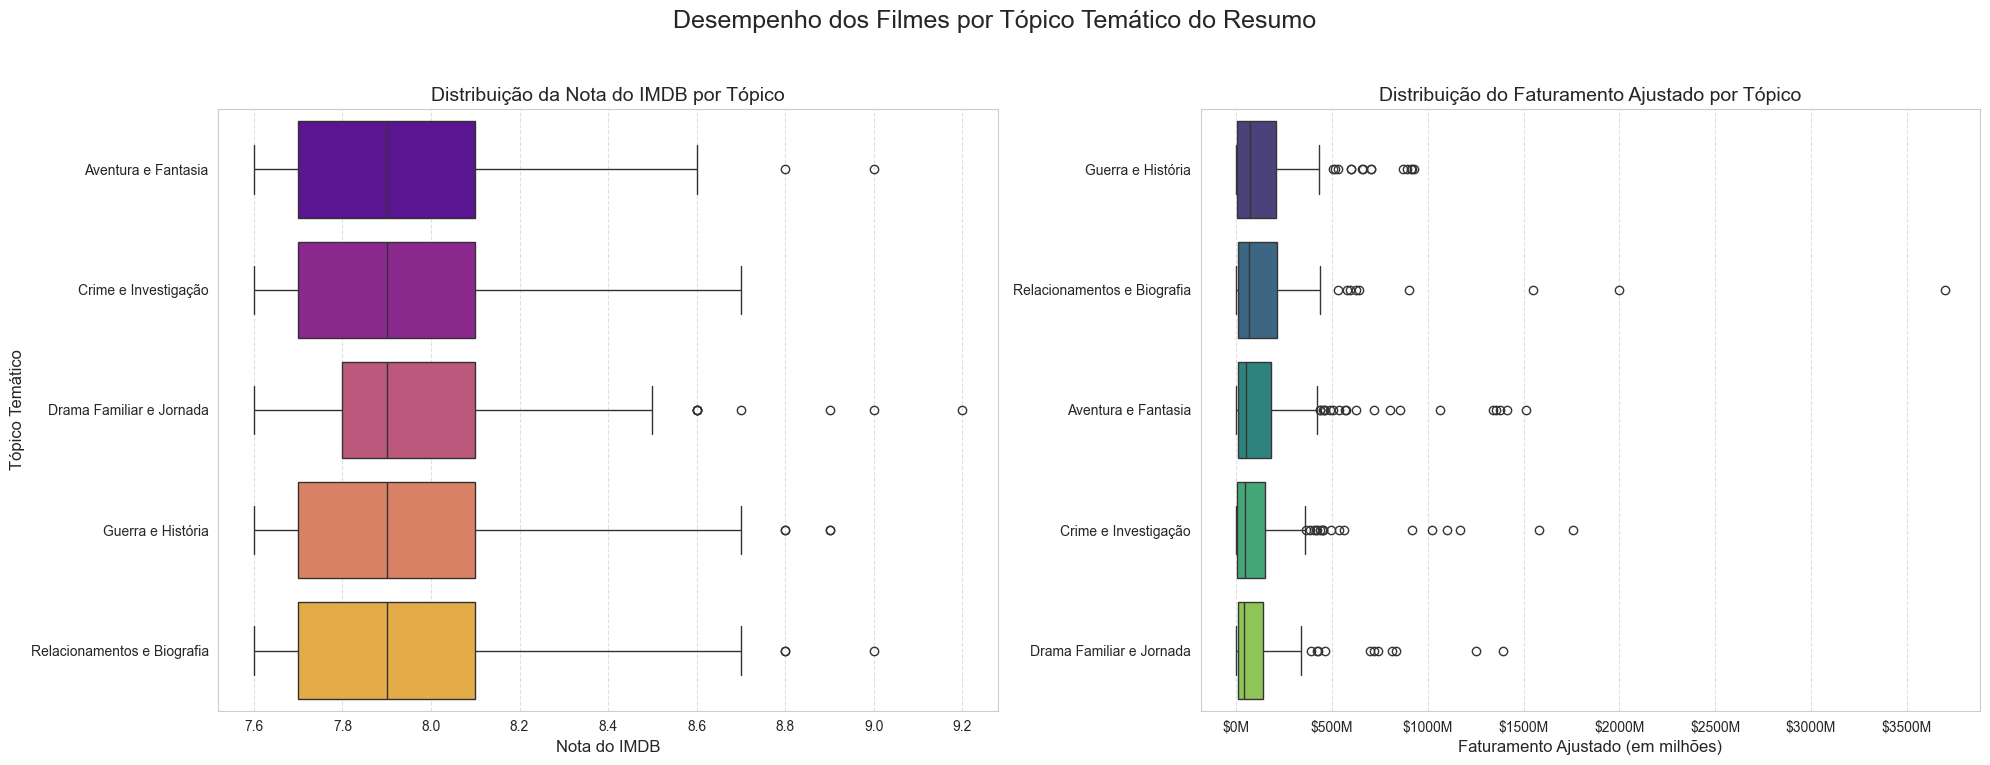

In [189]:

# Converte todos os resumos em uma matriz numérica de contagem de palavras
vectorizer_lda = CountVectorizer(stop_words='english', max_features=1000, max_df=0.8, min_df=5)
X_lda = vectorizer_lda.fit_transform(df_completo_futuro['Overview'])

# Cria e treina o modelo LDA para encontrar 5 tópicos
# n_components é o número de tópicos que queremos encontrar
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_lda)



# Função para exibir as palavras mais importantes de cada tópico
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Tópico #{topic_idx}: "
        message += " | ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("\nAs palavras mais importantes para cada Tópico descoberto:")
print_top_words(lda, vectorizer_lda.get_feature_names_out(), 10)

# Com base nas palavras acima, criamos um mapa para nomear os tópicos
# Esta é uma etapa de interpretação manual
topic_labels = {
    0: "Relacionamentos e Biografia",
    1: "Drama Familiar e Jornada",
    2: "Crime e Investigação",
    3: "Aventura e Fantasia",
    4: "Guerra e História"
}

# Atribui o tópico mais provável a cada filme em uma nova coluna
topic_results = lda.transform(X_lda)
df_completo_futuro['Topic_Num'] = np.argmax(topic_results, axis=1)
df_completo_futuro['Topic'] = df_completo_futuro['Topic_Num'].map(topic_labels)

print("\nCada filme foi associado a um tópico temático.")




fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Desempenho dos Filmes por Tópico Temático do Resumo', fontsize=18)

# Tópico vs. Nota do IMDB
order_imdb = df_completo_futuro.groupby('Topic')['IMDB_Rating'].median().sort_values(ascending=False).index
sns.boxplot(data=df_completo_futuro, y='Topic', x='IMDB_Rating', ax=axes[0], order=order_imdb, palette='plasma')
axes[0].set_title('Distribuição da Nota do IMDB por Tópico', fontsize=14)
axes[0].set_xlabel('Nota do IMDB', fontsize=12)
axes[0].set_ylabel('Tópico Temático', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.6)


# Tópico vs. Faturamento Ajustado
order_gross = df_completo_futuro.groupby('Topic')['Gross_Adjusted'].median().sort_values(ascending=False).index
sns.boxplot(data=df_completo_futuro, y='Topic', x='Gross_Adjusted', ax=axes[1], order=order_gross, palette='viridis')

def millions_formatter(x, pos): return f'${x / 1e6:.0f}M'
axes[1].xaxis.set_major_formatter(FuncFormatter(millions_formatter))
axes[1].set_title('Distribuição do Faturamento Ajustado por Tópico', fontsize=14)
axes[1].set_xlabel('Faturamento Ajustado (em milhões)', fontsize=12)
axes[1].set_ylabel('') # Remove o label Y para não repetir
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## C.2) É possível inferir o gênero do filme a partir dessa coluna(overview)? 

In [166]:
# Inferencia de gênero 

# Preparação dos Dados
X = df_completo_futuro['Overview']
y_genres_list = df_completo_futuro['Genre'].apply(lambda x: x.split(', '))
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_genres_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test_df = pd.DataFrame(y_test, index=X_test.index, columns=mlb.classes_)

# Criação e Treinamento do Pipeline
nlp_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000)),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')))
])
nlp_pipeline.fit(X_train, y_train)

# Demonstração com 10 Exemplos 
print("\nDemonstração da Previsão com 10 Exemplos")

amostras_aleatorias = X_test.sample(n=10, random_state=42)

for i, (indice_exemplo, overview_exemplo) in enumerate(amostras_aleatorias.items()):
    generos_reais_bin = y_test_df.loc[indice_exemplo].values
    
    # Modelo de predição
    generos_previstos_bin = nlp_pipeline.predict([overview_exemplo])
    
    # Converte a saída binária de volta para texto
    generos_reais = mlb.inverse_transform(np.array([generos_reais_bin]))
    generos_previstos = mlb.inverse_transform(generos_previstos_bin)
    
    # Imprime a comparação
    print(f"\nEXEMPLO {i+1}")
    print(f"Filme (índice): {indice_exemplo}")
    print(f"Resumo (Overview): \n'{overview_exemplo}'")
    print(f"Gêneros Reais:           {generos_reais[0]}")
    print(f"Gêneros Previstos pelo Modelo: {generos_previstos[0]}")


Demonstração da Previsão com 10 Exemplos

EXEMPLO 1
Filme (índice): 88
Resumo (Overview): 
'A married couple are faced with a difficult decision - to improve the life of their child by moving to another country or to stay in Iran and look after a deteriorating parent who has Alzheimer's disease.'
Gêneros Reais:           ('Drama',)
Gêneros Previstos pelo Modelo: ('Drama', 'Romance')

EXEMPLO 2
Filme (índice): 70
Resumo (Overview): 
'A former Prohibition-era Jewish gangster returns to the Lower East Side of Manhattan over thirty years later, where he once again must confront the ghosts and regrets of his old life.'
Gêneros Reais:           ('Crime', 'Drama')
Gêneros Previstos pelo Modelo: ('Biography', 'Drama')

EXEMPLO 3
Filme (índice): 595
Resumo (Overview): 
'When a new toy called "Forky" joins Woody and the gang, a road trip alongside old and new friends reveals how big the world can be for a toy.'
Gêneros Reais:           ('Adventure', 'Animation', 'Comedy')
Gêneros Previstos pelo

Mesmo tentando balancear os generos é possivel observar que o modelo ainda fica enviesado para propor 

In [151]:
# Verificando a frenquência por genero no dataset 
genre_counts = df_completo_futuro.assign(Genre=df_completo_futuro['Genre'].str.split(', ')).explode('Genre')['Genre'].value_counts(normalize=True) * 100

print("Frequência dos Gêneros no Dataset (%):")
print(genre_counts.head(10))

Frequência dos Gêneros no Dataset (%):
Genre
Drama       28.46
Comedy       9.17
Crime        8.23
Adventure    7.72
Action       7.44
Thriller     5.39
Romance      4.92
Biography    4.29
Mystery      3.90
Animation    3.23
Name: proportion, dtype: float64


# Previsão

In [168]:
# O problema é de REGRESSÃO para prever a nota do IMDB.
target = 'IMDB_Rating'
# Usamos as features mais relevantes, incluindo a 'Certificate_Harmonized'.
# Excluímos 'Certificate' e 'Genre' originais.
features = ['Released_Year', 'Runtime', 'Meta_score', 'No_of_Votes', 'Gross_Adjusted', 'Certificate_Harmonized']

X = df_completo_futuro[features]
y = df_completo_futuro[target]

# Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Dados divididos em {len(X_train)} para treino e {len(X_test)} para teste.")

Dados divididos em 799 para treino e 200 para teste.


In [171]:
# Identifica automaticamente as colunas numéricas e categóricas
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# Pipeline para tratar features numéricas: preenche NaNs com a mediana e padroniza a escala
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para tratar features categóricas: preenche NaNs com o valor mais frequente e aplica One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Junta os dois pipelines em um único pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [182]:

# Pré-processa os dados de treino e teste uma vez
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Definindo os modelos e dicionarios de parametros

modelos = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Dicionário com as grades de parâmetros para cada modelo a ser otimizado
param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [5, 10],
        'min_samples_leaf': [2, 4]
    },
    "SVR": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    "K-Nearest Neighbors": {
        'n_neighbors': [3, 5, 7, 9]
    },
    "XGBoost": {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1]
    }
}

In [183]:
# Otimização e avaliação

resultados = []

for nome, modelo in modelos.items():
    print(f"\nProcessando modelo: {nome}...")
    
    # Se o modelo não tem uma grade de parâmetros, apenas treina e avalia
    if nome not in param_grids:
        modelo.fit(X_train_processed, y_train)
        best_params = "N/A"
        best_estimator = modelo
    else:
        # Se tem uma grade, executa o GridSearchCV
        grid_search = GridSearchCV(
            estimator=modelo,
            param_grid=param_grids[nome],
            scoring='neg_root_mean_squared_error',
            cv=5,
            verbose=0,
            n_jobs=-1
        )
        grid_search.fit(X_train_processed, y_train)
        best_params = grid_search.best_params_
        best_estimator = grid_search.best_estimator_
        print(f"  Melhores parâmetros: {best_params}")

    # Avaliação final no conjunto de teste
    y_pred = best_estimator.predict(X_test_processed)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    resultados.append({'Modelo': nome, 'Melhor RMSE (CV)': -grid_search.best_score_ if nome in param_grids else rmse, 'RMSE (Teste)': rmse, 'R² (Teste)': r2, 'Melhores Parâmetros': best_params})



Processando modelo: Linear Regression...

Processando modelo: Random Forest...
  Melhores parâmetros: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}

Processando modelo: SVR...
  Melhores parâmetros: {'C': 1, 'kernel': 'rbf'}

Processando modelo: K-Nearest Neighbors...
  Melhores parâmetros: {'n_neighbors': 9}

Processando modelo: XGBoost...
  Melhores parâmetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [188]:
# Resultados
resultados_df = pd.DataFrame(resultados).sort_values(by='RMSE (Teste)', ascending=True)

print("\n\nTabela Comparativa de Performance dos Modelos Otimizados")
# Usando display para melhor visualização no notebook
pd.set_option('display.max_colwidth', None)
display(resultados_df)



Tabela Comparativa de Performance dos Modelos Otimizados


,Modelo,Melhor RMSE (CV),RMSE (Teste),R² (Teste),Melhores Parâmetros
1,Random Forest,0.19,0.20,0.37,"{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}"
4,XGBoost,0.19,0.20,0.37,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}"
2,SVR,0.20,0.21,0.30,"{'C': 1, 'kernel': 'rbf'}"
0,Linear Regression,0.22,0.22,0.28,N/A
3,K-Nearest Neighbors,0.21,0.22,0.27,{'n_neighbors': 9}


In [186]:
# Pega o valor de CPI para o ano de 1994
cpi_1994 = df_cpi_anual.loc[df_cpi_anual['Year'] == 1994, 'CPI'].iloc[0]

# Cria o dicionário com as colunas necessárias para o modelo
shawshank_data = {
    'Released_Year': [1994],
    'Runtime': [142],
    'Meta_score': [80.0],
    'No_of_Votes': [2343110],
    'Gross': [28341469], # O modelo espera o Gross original
    'Certificate_Harmonized': ['Adulto'], # Usamos a versão harmonizada
    
    # Calculamos o Gross_Adjusted separadamente, pois ele pode não ser uma feature no modelo final
    # mas o incluímos aqui para consistência.
    'Gross_Adjusted': [28341469 * (cpi_base / cpi_1994)]
}

# Cria o DataFrame completo
shawshank_df = pd.DataFrame(shawshank_data)

# Seleciona apenas as colunas que o modelo espera, na ordem correta
shawshank_df_para_previsao = shawshank_df[features]

print("DataFrame para previsão final, com as colunas corretas:")
display(shawshank_df_para_previsao)

DataFrame para previsão final, com as colunas corretas:


,Released_Year,Runtime,Meta_score,No_of_Votes,Gross_Adjusted,Certificate_Harmonized
0,1994,142,80.00,2343110,"49,486,177.48",Adulto


In [187]:
# Melhores parâmetros encontrados para o XGBoost
melhores_parametros_xgb = {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}

# Pipeline final com o modelo otimizado
modelo_final_otimizado = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **melhores_parametros_xgb))
])

# Treina o modelo final com  todos os dados de treino
modelo_final_otimizado.fit(X_train, y_train)
print("Modelo final com hiperparâmetros otimizados foi treinado!")

# Previsão para o caso específico
# ... (código para o shawshank_df) ...
predicted_rating = modelo_final_otimizado.predict(shawshank_df)
print(f"\nA nota final prevista para o filme de exemplo é: {predicted_rating[0]:.2f}")


# Salvando o modelo final otimizado
joblib.dump(modelo_final_otimizado, 'modelo_previsao_imdb_otimizado.pkl')
print("\nModelo final otimizado salvo com sucesso!")

Modelo final com hiperparâmetros otimizados foi treinado!

A nota final prevista para o filme de exemplo é: 8.78

Modelo final otimizado salvo com sucesso!
